In [1]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

import itertools

# Exercise 1 - REINFORCE

The goal of this exercise is to implement the simplest policy gradient algorith, REINFORCE, and then augment it with a baseline coming from an approximation of the value function. We will use this algorithm on the inverted pendulum model. The class below defines the pendulum model and some helper function to simulate it.

In [2]:
class Pendulum:
    """
    This class describes an inverted pendulum and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class
        """
        #gravity constant
        self.g=9.81
        
        # number of dimensions (angle and angular velocity)
        self.num_states = 2
        
        # the available control inputs
        self.controls = np.array([-5., 0., 5.])
        self.nb_controls = len(self.controls)

        # the maximum velocity
        self.vmax = 6.
        # the range of allowable states
        self.state_range = np.array([[0, 2*np.pi],[-self.vmax, self.vmax]])

        #simulation step
        self.delta_t = 0.1
        # internal integration step
        self._internaldt = 0.01
        self._integration_ratio = int(round(self.delta_t / self._internaldt))
        
            
    def step(self,x,u):
        """
        This function integrates the pendulum for one step of self.delta_t seconds
        
        Inputs:
        x: state of the pendulum (x,v) as a 2D numpy array
        u: control as a scalar
        
        Output:
        the state of the pendulum as a 2D numpy array at the end of the integration
        """
        x_next = x[0]
        v_next = x[1]
        for i in range(self._integration_ratio):
            x_next = (x_next + self._internaldt * v_next)%(2*np.pi)
            v_next = np.clip(v_next + self._internaldt * (u-self.g*np.sin(x_next)), -self.vmax, self.vmax)
        return np.array([x_next,v_next])
    
    def simulate(self, x0, policy, T):
        """
        This function simulates the pendulum for T seconds from initial state x0 using a policy
        (policy is called as policy(x) and returns one control)
        
        Inputs:
        x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
        T: the time to integrate for
        
        Output:
        x (2D array) and u (1D array) containing the time evolution of states and control
        """
        horizon_length = int(T/self.delta_t)
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([horizon_length])
        for i in range(horizon_length):
            u[i] = policy(x[:,i])
            x[:,i+1] = self.step(x[:,i], u[i])
        return x, u

In [3]:
def animate_pendulum(x, dt):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation - dt is the sampling time (0.1s normally)
    """
    
    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    plotx = x[:,::steps]
    
    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)
    
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])
        
        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

This function can be used to plot the results of a simulation of the pendulum

In [4]:
def plot_results(pend, val, pol, policy, animate=True):
    """
    This function plots the results. It displays the value function, the policy for all states.
    Then it integrates the pendulum from state [0,0] and displays the states and control as a function of time
    Finally it shows an animation of the result
    """
    x0 = np.array([0.,0.])

    x, u = pend.simulate(x0, policy, 10)

    plt.figure(figsize=[6,6])
    plt.imshow(val, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')

    plt.figure(figsize=[6,6])
    plt.imshow(pol, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')

    time = np.linspace(0.,20., len(x[0,:]))
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time,x[0,:])
    plt.ylabel('angle')
    plt.subplot(3,1,2)
    plt.plot(time,x[1,:])
    plt.ylabel('velocity')
    plt.subplot(3,1,3)
    plt.plot(time[:-1],u)
    plt.ylabel('control')
    if animate:
        animate_pendulum(x, pend.delta_t)

## Reinforcement learning problem

We would like to get the pendulum upright starting from the down rest position. It has two states, its angle $\theta$ (where $\theta=0$ means that the pendulum is down) and its angular velocity $\omega$. The state of the system is $x = [\theta^T \omega^T]^T$. We also assume that we have only 3 possible control inputs $[-5, 0, 5]$.

We formulate this problem as a finite horizon problem where we want to minimize the cost
$$\min \sum_{i=0}^{N} \alpha^i g(\theta_i, \omega_i, u_i)$$
where the instantaneous cost is $$g(x,v,u) = (x-\pi)^2 + 0.01 v^2 + 0.00001 u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls

## Stochastic policies

We will use stochastic policies $\pi(u | x,\theta_\pi)$ that are parametrized by $\theta_\pi$ (i.e. the parameters to learn). We will use exponential softmax distributions $$\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$$ where in the denominator we sum over the 3 possible controls.
The function $h(x,u,\theta_\pi)$ is a function which reflects the preference of a control for a given state. We will use a linear combination of nonlinear basis functions to define it as
$$h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$$
where $$\Psi(x,u) = [\psi_0(x,u), \cdots, \psi_m(x,u)]^T$$ is a vector of $m$ nonlinear basis functions.
In our exercise, we use periodic basis functions. For a given order $p$, we define $m = 6 (p+1)^2$ basis functions as
$$\psi_{k,l,c,0}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
and
$$\psi_{k,l,c,1}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
where $0\leq k \leq p$ and $0 \leq l \leq p$ are integers, $u_c$ is the control indexes by $c$ (i.e. it is either -5, 0 or 5) and $\omega_{max}$ is the maximum velocity of the pendulum (in order to get one period over the full range of $\omega$). Note that $\theta$ already ranges from $0$ to $2\pi$.

The class below defines these stochastic policies as well as helper functions to sample from the policy, get the vector of basis functions and get the probability distribution $\pi(.|x,\theta_\pi)$

In [5]:
class StochasticPolicyPeriodicFeatures:
    """
    This class implements a stochastic policy with linear sum of nonlinear features
    the features are periodic functions multiplied by a radial basis function of u
    """
    def __init__(self, controls, order = 2):
        """
        class constructor - controls is the array of control inputs, order is the order of the periodic basis
        """
        self.controls =  controls.copy()
        self.num_controls = len(self.controls)
        self.exp_basis = np.zeros([self.num_controls])
        self.order = order
        
        # the vector of basis functions
        self.basis_vector = np.zeros([2*self.num_controls*(self.order+1)**2])
        
        # the linear parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x, u):
        """
        Returns the vector of basis functions evaluated at x,u
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for c in self.controls:
            du = 1/(np.sqrt(2*np.pi*0.001)) * np.exp(-(u-c)**2/0.002)
            for j,k in itertools.product(range(self.order+1), range(self.order+1)):
                self.basis_vector[count] = du * np.cos(j*dx + k*dy)
                self.basis_vector[count+1] = du * np.sin(j*dx + k*dy)
                count += 2
        return self.basis_vector

    def get_distribution(self, x):
        """ 
        Computes pi(u|x) for all u 
        returns an array of pi and an array of basis functions (row is the control index and column is the )
        """
        dist = np.zeros_like(self.controls)
        basis_fun = np.zeros([len(self.theta), len(self.controls)])
        for i,u in enumerate(self.controls):
            # this gives the basis function evaluated as (x,u)
            basis_fun[:,i] = self.basis(x,u)
            # dist gives exp(theta * basis_function)
            dist[i] = np.exp(self.theta.dot(basis_fun[:,i]))

        # we sum the exponentials
        sm = np.sum(dist)
        # dist is rescaled by the sum of exponentials (we now have a probability distribution)
        dist = dist/sm
        return dist, basis_fun
    
    def sample(self, x):
        """
        sample from the stochastic policy given x
        it returns the index of the control and its value
        """
        probs, basis = self.get_distribution(x)
        index = np.random.choice(len(self.controls), p=probs)
        return index, self.controls[index]

## Value function approximation

We also use a function approximator for the value function (used for the REINFORCE algorithm with baseline). We will write our approximation of the value function as
$$V(x,\theta_V) = \theta_V^T B(x)$$
where the vector of basis functions $B$ is also constituted of periodic functions of the form
$$b_{k,l,0}(\theta,\omega) = \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$ and
$$b_{k,l,1}(\theta,\omega) = \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$

The class below implements such a value function approximation

In [6]:
class ValueFunctionPeriodicFeatures:
    """
    This class implements a function approximator with linear sum of nonlinear features
    the features are periodic functions
    We use this to approximate the value function
    """
    
    def __init__(self, order = 2):
        """
        the class constructor - order is the order of the periodic basis
        """
        
        self.order = order
        self.basis_vector = np.zeros([2*(self.order+1)**2])

        # the parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x):
        """
        Returns the vector of basis functions evaluated at x
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for j,k in itertools.product(range(self.order+1), range(self.order+1)):
            self.basis_vector[count] = np.cos(j*dx + k*dy)
            self.basis_vector[count+1] = np.sin(j*dx + k*dy)
            count += 2
        return self.basis_vector
    
    def getValue(self, x):
        """
        returns the value at x and the basis functions evaluated at x
        """
        bs = self.basis(x)
        return bs.dot(self.theta), bs

## REINFORCE

We want to implement the REINFORCE algorithm (where an iteration is shown below):
1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
2. For each step $t$ of the episode
 * compute the return G_t = \sum{k=t}^T \alpha^{k-t}g(x_k, u_k)
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t G_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ is a learning rate
 
 ## REINFORCE with baseline
 
 The REINFORCE with baseline algorithm, in addition, maintains an estimate of the value function. One iteration is
 1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
 2. For each step $t$ of the episode
 * compute the return G_t = \sum{k=t}^T \alpha^{k-t}g(x_k, u_k)
 * \delta = G_t - V(x_t, \theta_V)
 * do gradient ascent on the value parameters $\theta_V \leftarrow \theta_V + \gamma_V \alpha^t \delta \nabla V(x_t, \theta_V)$
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t G_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ and $\gamma_V$ are learning rates

## Questions

a) Compute $\nabla V(x, \theta_V)$ with respect to $\theta_V$ for a generic function $ V(x, \theta_V) = \theta_V^T B(x)$

b) Compute $\nabla \ln \pi(u_t | x_t, \theta_\pi)$ with respect to $\theta_\pi$ for a stochastic policy parametrized as $\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$, with $h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$

c) using the previous computations, the classes above (optional) and code skeleton below (also optional), implement the REINFORCE algorithm for the inverted pendulum. Use $\alpha = 0.99$, an episode length of 100 (i.e. 10 seconds) and order p=2 for the policy approximation. Hint: you may want to choose a learning rate between $10^{-8}$ and $10^{-11}$. How many episodes does it take to converge? Can the resulting policy (which is stochastic) balance the pendulum appropriately? (note you may want to test several times due to the stochasticity). Plot the learning progress (costs versus episodes), you may also want to use a moving average over the costs to remove noise.

d) implement the REINFORCE algorithm with baseline and answer the same questions as in c) (also use an order p=2 for the value function approximation). Additionally, plot the value function. Hint: you may want to choose a learning rate between $10^{-6}$ and $10^{-9}$ for updating the policy and a learning rate between $10^{-1}$ and $10^{-3}$ to update the value function.

e) Compare the convergence rate of both algorithms. Which one seem to be easier to use?

You can use the code skeleton below to answer the questions

In [7]:
class Reinforce:
    """
    An implementation of the reinforce algorithm (with or without baseline)
    """
    
    def __init__(self, model, cost, policy, discount_factor=0.99, 
                 episode_length=100, policy_learning_rate = 0.000001):
        """
        the class constructor
        """
        self.model = model
        self.cost = cost

        self.policy = policy
        
        self.discount_factor = discount_factor
        self.episode_length = episode_length
        
        self.policy_learning_rate = policy_learning_rate
            
    def iterate(self, num_iter=1):          
        """
        the main loop
        """
        learning_progress = []
        
        # here we allocate some useful vectors
        x_traj = np.zeros([self.episode_length+1, self.model.num_states])
        u_traj = np.zeros([self.episode_length, 1])
        u_index = np.zeros([self.episode_length], dtype=np.int)
        cost_traj = np.zeros([self.episode_length])
        
        for i in range(num_iter):  
            # generate an episode - start from 0
            x_traj[0,:] = np.zeros([2])
            # TO COMPLETE #
            # you can use the step function of self.model (i.e. the pendulum) to get the next state
            
            # now compute the returns Gt and update the policy parameters self.policy.theta through gradient descent
            # TO COMPLETE #

            # here we store the return at t=0 to get the learning progress
#             learning_progress.append(G)
                
        return learning_progress
            
    def get_Policy(self):
        """
        This helper function generate a 50x50 grid (theta x omega) with a policy (for display)
        the policy is computed as the expected control from pi
        we also compute a value function (to be used for the baseline part) - for now it is 0
        """
        n_discrete = 50
        pol = np.zeros([n_discrete,n_discrete])
        val = np.zeros([n_discrete,n_discrete])
        x_range = np.linspace(self.model.state_range[0,0], self.model.state_range[0,1], n_discrete)
        v_range = np.linspace(self.model.state_range[1,0], self.model.state_range[1,1], n_discrete)
        
        for i, x in enumerate(x_range):
            for j,v in enumerate(v_range):
                dist, basis = self.policy.get_distribution(np.array([x,v]))
                pol[i,j] = dist.dot(self.model.controls)
                # this can be used later to get a value estimate
                # val[i,j] = self.value.getValue(np.array([x,v]))[0] 
        return pol, val

def cost(x,u):
    """
    the cost function for the inverted pendulum
    """
    return (x[0] - np.pi)**2 + 0.01*x[1]**2 + 0.0001*u

In [8]:
# here we create all the objects
pendulum = Pendulum()
policy = StochasticPolicyPeriodicFeatures(controls = pendulum.controls, order = 2)
# to be used for the baseline
# value = ValueFunctionPeriodicFeatures(order = 2)
reinforce = Reinforce(pendulum, cost, policy, episode_length=100, 
                      discount_factor=0.99, policy_learning_rate = 0.00000001)

<IPython.core.display.Javascript object>


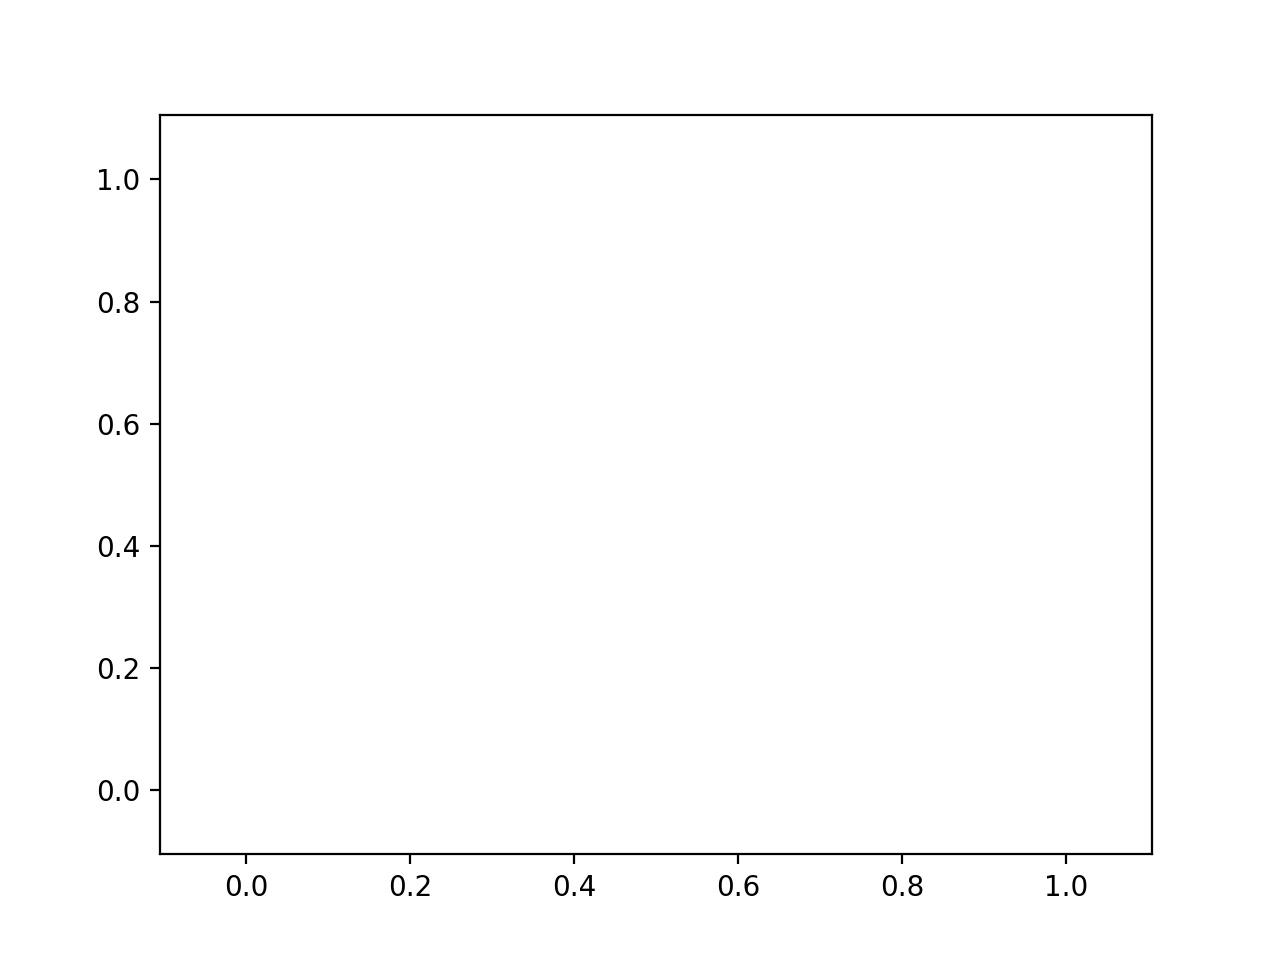

<IPython.core.display.Javascript object>


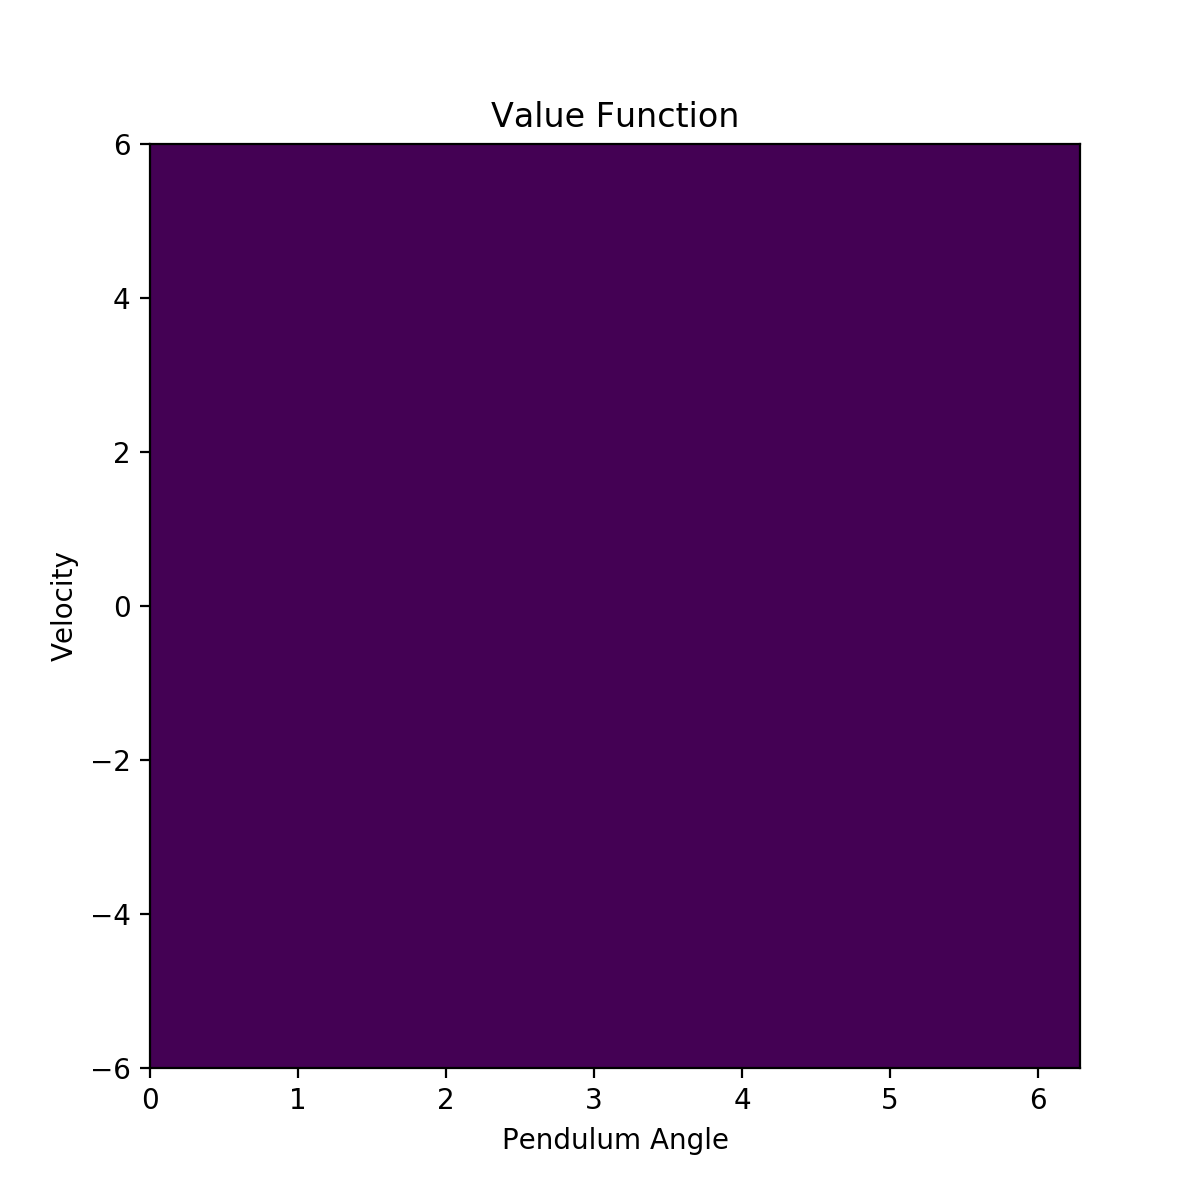

<IPython.core.display.Javascript object>


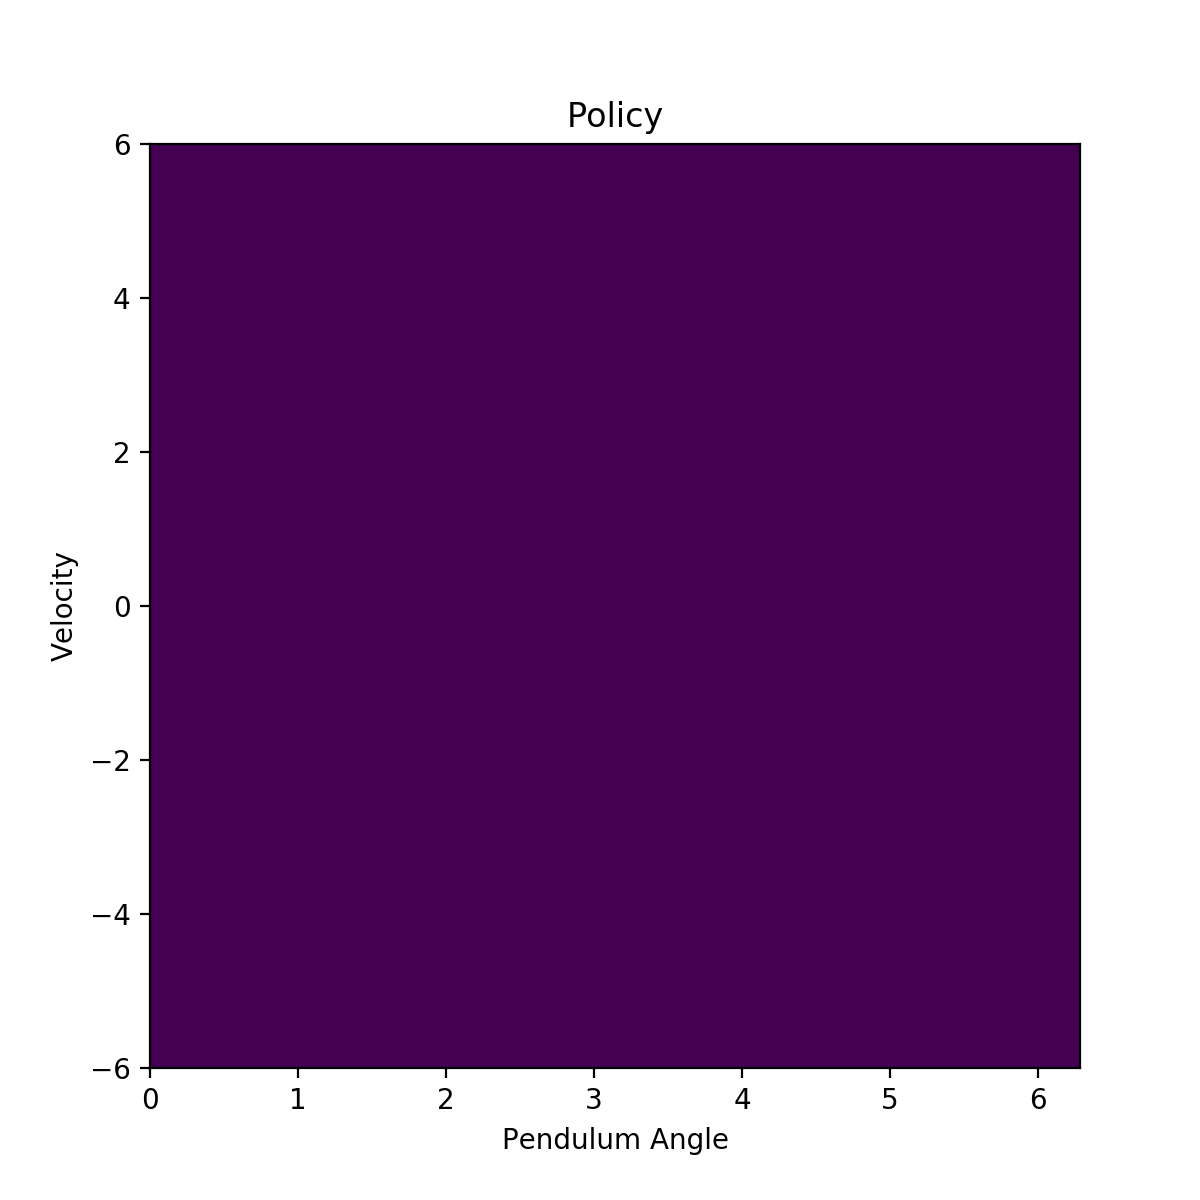

<IPython.core.display.Javascript object>


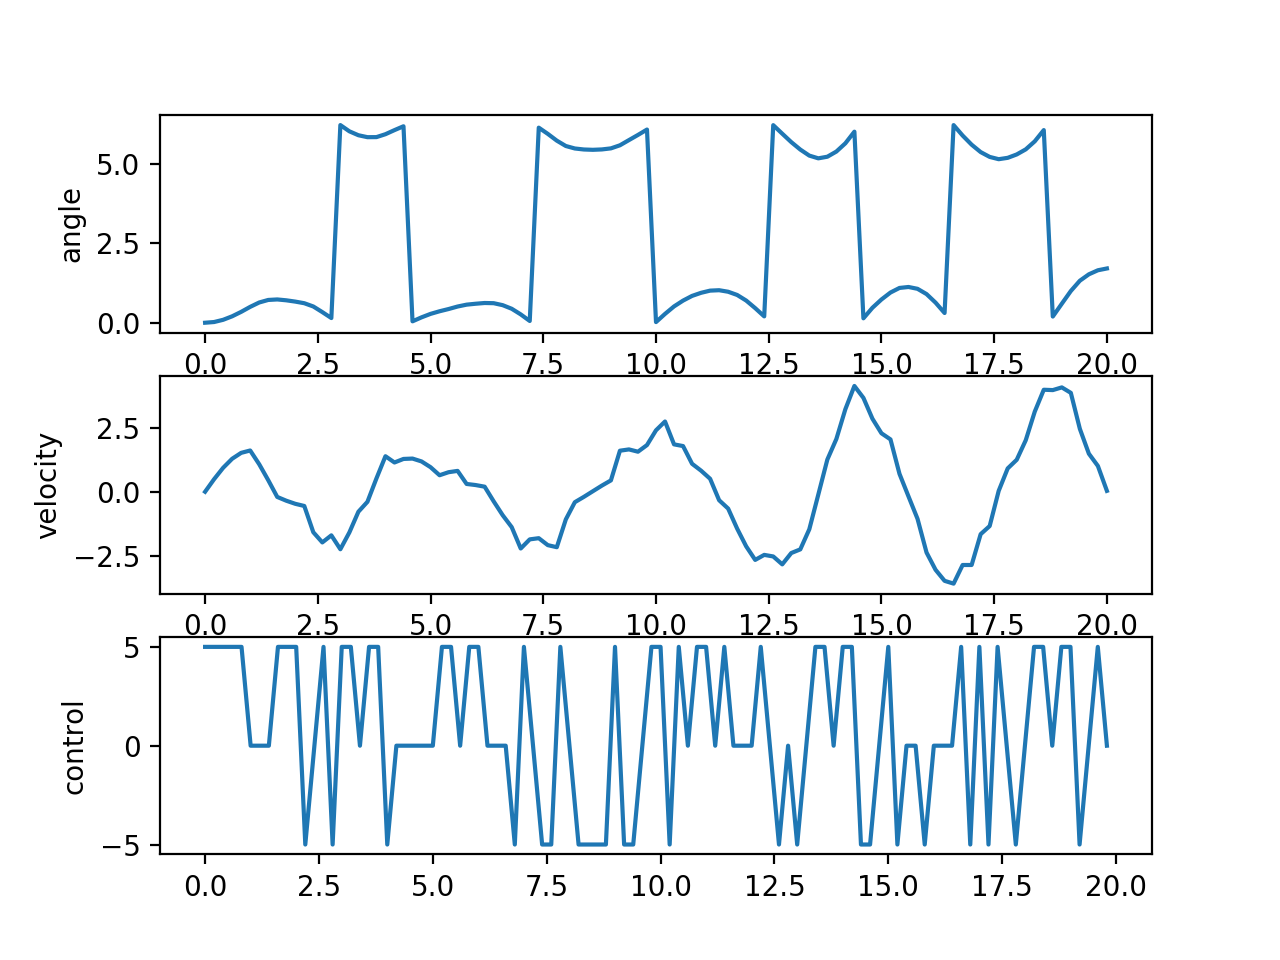

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAADPXG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTIgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAANAWWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAAFHh7Xrjd2DW0nQAAAawAOkIsf/
b6Q43ABP2WD81iMv8WgH1qIriMT5itg+8zdUlji+M2fIsY/ZiVsmn82kDyT4LpjCkOVefZ/LVM31
A0tLZ2hiDXqcDcoEggKOtjY9CMYb+UlaCRVGKZr2OzpXHlaKZtCu3vYi2M0vuwvESUQDXuaEJ5Zs
DvPJdE4HxzWrAHAbqYXhn2nhFy2Zh1jvl9n08hwvr7UO02jXn0Owh50dZbkF56hR4wivXn4sj/qr
urfC7+UNk320iVM7NEnmHG6sJrpM/dh0nQ+5r39OQ6cHUFm0hB1kTY014bpkFYpfap7yuKujiFUe
ToArWbelIEViS5sHONVtvlrOMCzrt3jjVSp/FAh1kALfBcaF3QN/iyMCwCJRDeL1+W9gvs0B80OX
771qo1L6b8Se0JHCoJ7wEjiH5fq1czRmUja6Lt+cJs+vOmsK6v9CW/8BxbCHY8I9Xbsn0eEHixtG
mbYiX0kSwaoAqsWO2r/Ap+Q0l5RQlGoI7w7gE1OQzWCRS3/hhgO94rq8rGuvXEYifEEWRHFFr9TW
rroVjms8pEa/L+WEJXSAs9Yz9TB3gALLRCydF8v7d7OWJmbzbbxmIJAz8FvseKH41Th8/NWZfIVd
vJtZPeruqXI525uDTs4MabfAFEyANiImheUqzkFCLTmr3RC+nngsdm+UAFztrPOAAACWGCjlTTK5
eii9n3eaPlzQDiRWJObB82UU3jbauuaRjT5MlePLZARODEf5WMtQZbidqGpSBZCoMx+dED2VzE6m
+6XQQDByZT/QANou+MWKX23sVRgo3FPoc8omX1s5YtioT4LLf3+YHyY37YL3JOB4uQBhU2NbrYXz
av8CpULYFu5mnhUH4n116645yIhQCKEfWapzkYyHwpmbJ24IaLuMFwTwYorsq2GjVZpPuHSge5kO
+ED6g3uvjHH8tTvZ7qfvizE4//hgfBisLHi66dWh8i+oPIjy1T1V8ELKaPr5p6Jtq+e1mPITq+l9
ue1v0+ljPzIM3mz/+icmdJ14LAOULbN+ecMXn+LrhUWxSjN3LOg4AVn+Y6XLwEya6cJftx8Ros7Z
fYfXKwOqyGx5oihfBbKBotiaDRx+9fC427CuUHcCqyWrd2aof5uSX8gxM8sthZLUL2GSa9etyWRP
BtcblR6+jz9jz6cKIfcP9mrsXaAo0tq8T7YA/3kd3YSQ+UNsF7v3PawrYbNY0eRekqhMFcTuxmzd
fgZ3XRGvU72ZYXLIKLkHK9MoThyrJohoah16nIsbm10y7sj1sDV+5NstppEphicW6SPKwKlmxy6e
qv0L8bqTaWhTlc5s0BdbXPqPpoKw5qmzeYr/kSBegbYNjDeSTBcaA57SfJfCzo2aPVc74ZwLkr2o
26TSEIEPHbaEnVHAOE/sYHKV8ZIfRYh8WXGxw1447XXNIYB+iNGGOlIAZmqqvkJdgrYe21tErwU2
6pe6ZvyPs6xuZrj6hZX9jNWz6+FgaAIhBTOo/NjSoCeoptqa17Zypy1T9w/8CJiO02rREs8Nlft9
y/ZS0aKyaO7BWn+yt4F08W/+BxOujiZ6qpaE1g7jg6JvceGAynFU7d7jP9s3d9EErVy3xf+NICfV
/vjIE091Ub36jHYskrxVgxRMFHHAahYF/iobGWPrLuG7YZO+NRJlsHlDs5dWhSq9J/6alluiwlYn
GL3XpOfAi7cVVeBlYS46W/S52sX3Hmez0ywbheSLkoFPxUpX5ack91Wen5J7v89Dn5kF9rya3dEc
Tl/TRjiK9LdwbXvkyWRK+2hZzE5kjMdBetdhXIKTepb/6fG4p98FaNTQ9oadFYlGtg0Idnbv36oH
6W8id6kW7REcH1Ba93cReBCcXxy3GSgMc096KkPu8PZ70m4CrK7UsFSkJ0Dgai4tD6iGPsLYagAw
1t7Fb6VjfvgEkc+T0bnvAH+oeBlRZsb15Qwe1lJTBaH3y2N10kKhlJqGvYnGVlfhcxLnqWgs9542
EuQLlX9tFub89PKvNvsGNmbrN91y62+GmbZR0yPRFbxKFMk709bCH5/S6NQpWOtuuXBNfcmRVjJ6
WgEsXVwjyl8/MrlSIJmtvj1bPRxvKjJHSgmxdxnqN+C7dfyUAiobnZnDF5OPM9ap39fvZyLHq0EX
e2ltUrbG7jGCQlaEPeL5/9rVoxd9A+yvTm2aSvjt8KZ/uJTUlzHXVlo6TOvDRREaUBSSZQsZqKwr
NdqNeZidnFdriNwo5Ckk556NvX1Ba/KF5qhGrOSZTItEX9QI3zvq7zpiztgNDqO7jmftHvE4LLP5
kmofINgh9IpG4TtwNE7DstgGKYNPJqWxJ4Vf4B1XP2hbSOgAKU4DkMkkQFT2DUxe9t876aEAAAMA
rQAAHAq0nnBytrd8Ds4WjPBfSpQ8oXFs4D9es+hDoBa1tVC4bqz4qeNPnmAnCh9rnxmJ1do7HmrT
zbzxRaevj2CrXr3/7pS+pNSnXvFyMLZRIWXNNlahu0zzxm0bbWBL+vbzyB6pbvPLWfHmBlcrZWSI
hAIdbf9CL+zt6ON/qy8LIeS3YH4tvqHSDF9pZS541X3UtAHOJMpTaiujtHZ7XOFCA2kKqBSajAqN
K85azA3dVuOV1/dyvtRV4d+ofxiN1qKMz/Rf/UU03i0MnlQZWgx1k/diPdVOiOf9U7W7rwWPDoKp
kvp2x43AT+O3/pxV1bzzmDXn2hRJwNMo2VlAlG654iQvjUC3QOR5RDiZ/uGG3gTU5DMazlj//Zm3
SIE8d9qxbg4fwLOG4jEkN47M67IB6RqyZw27SpiHnR+n7EpDLwd4pikk3pi+PNhS1MvfmdUt/Byr
jTY3gKykbakgisWwsZ4Xo

In [9]:
# here we learn doing 300 episodes
lear = reinforce.iterate(300) #you will likely need more than 300 episodes!

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear)
ret = np.cumsum(lear)
win_avg = 20
ret[win_avg:] = ret[win_avg:] - ret[:-win_avg]
plt.plot(ret[win_avg - 1:] / win_avg)

# we get the policy/value as arrays
pol, val = reinforce.get_Policy()
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum, val, pol, control_policy, animate=True)